In [1]:
!pip install pmdarima
!pip install common

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for common: filename=common-0.1.2-py3-none-any.whl size=3708 sha256=e3f5208169e57c59f196efe6ef757a4f0ca4fcc50201dc0838f682d191ced123
  Stored in directory: /root/.cache/pip/wheels/12/f4/3f/8982873f5bfad3134251f605011de0c35f93d64b78cb07e3b8
Successfully built common


In [2]:
!pip show scikit-learn


Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import pmdarima
import json

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from pmdarima import auto_arima

# Serialization (saving the model)
import joblib
from joblib import dump, load


In [4]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [4]:
path = 'drive/MyDrive/_Machine_Learning/project_energen/'

In [5]:
energy_df = pd.read_csv(path + 'data/energy.csv')

In [6]:
energy_df.head(10)

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000
5,2012-01-01 05:00:00,2453.0,31.333333
6,2012-01-01 06:00:00,2560.0,30.000000
7,2012-01-01 07:00:00,2719.0,29.000000
8,2012-01-01 08:00:00,2916.0,29.000000
9,2012-01-01 09:00:00,3105.0,33.333333


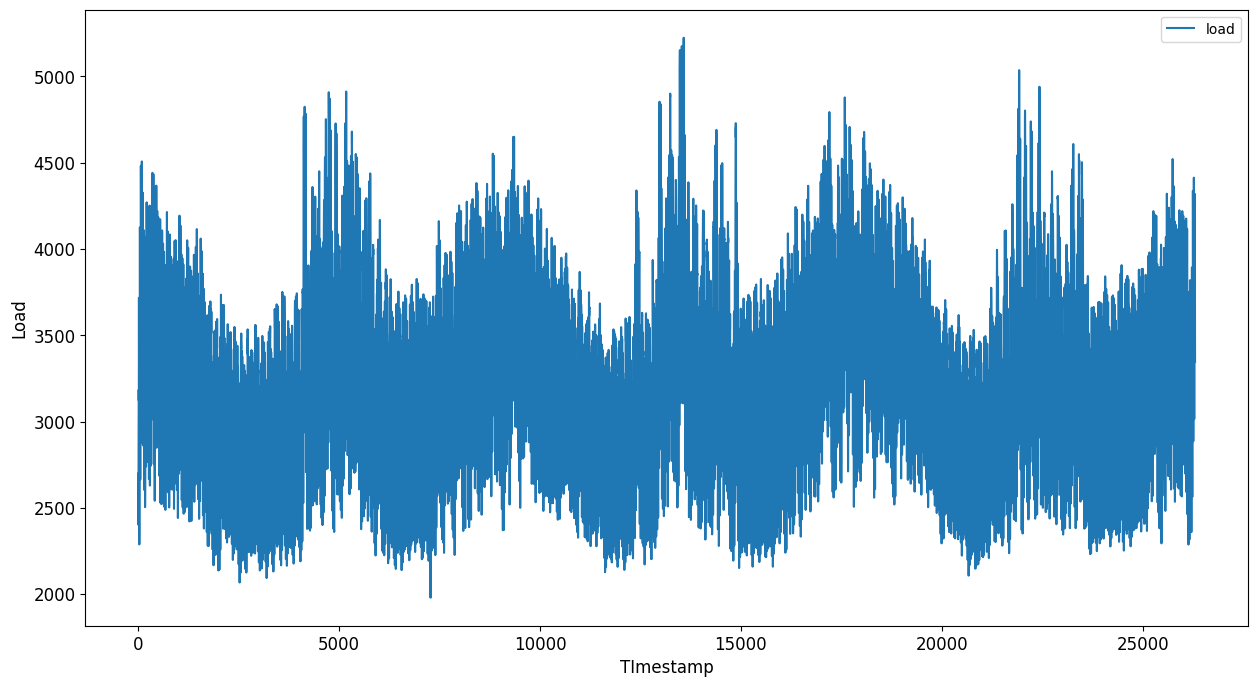

In [7]:
energy_df.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('TImestamp', fontsize=12)
plt.ylabel('Load', fontsize=12)
plt.show()

In [8]:
energy_df['timestamp'] = pd.to_datetime(energy_df['timestamp'])
energy_df = energy_df.set_index('timestamp')
# energy_df['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
# plt.xlabel('Timestamp', fontsize=12)
# plt.ylabel('Load', fontsize=12)
# plt.show()

In [39]:
energy_df.info()
type(energy_df.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2012-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    26304 non-null  float64
 1   temp    26304 non-null  float64
dtypes: float64(2)
memory usage: 1.6 MB


pandas.core.indexes.datetimes.DatetimeIndex

## Create training and testing datasets

In [10]:
#two-month period from september 1 to October 31
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

In [12]:
# energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
#     .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
#     .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
# plt.xlabel('timestamp', fontsize=12)
# plt.ylabel('load', fontsize=12)
# plt.show()

In [11]:
result = energy_df.loc[train_start_dt:, ["load"]].copy()

result["train"] = result["load"].where(result.index < test_start_dt)
result["test"]  = result["load"].where(result.index >= test_start_dt)

result = result.drop(columns="load")


In [12]:
result

,train,test
timestamp,,
2014-11-01 00:00:00,2514.0,NaN
2014-11-01 01:00:00,2434.0,NaN
2014-11-01 02:00:00,2390.0,NaN
2014-11-01 03:00:00,2382.0,NaN
2014-11-01 04:00:00,2419.0,NaN
...,...,...
2014-12-31 19:00:00,NaN,4012.0
2014-12-31 20:00:00,NaN,3856.0
2014-12-31 21:00:00,NaN,3671.0


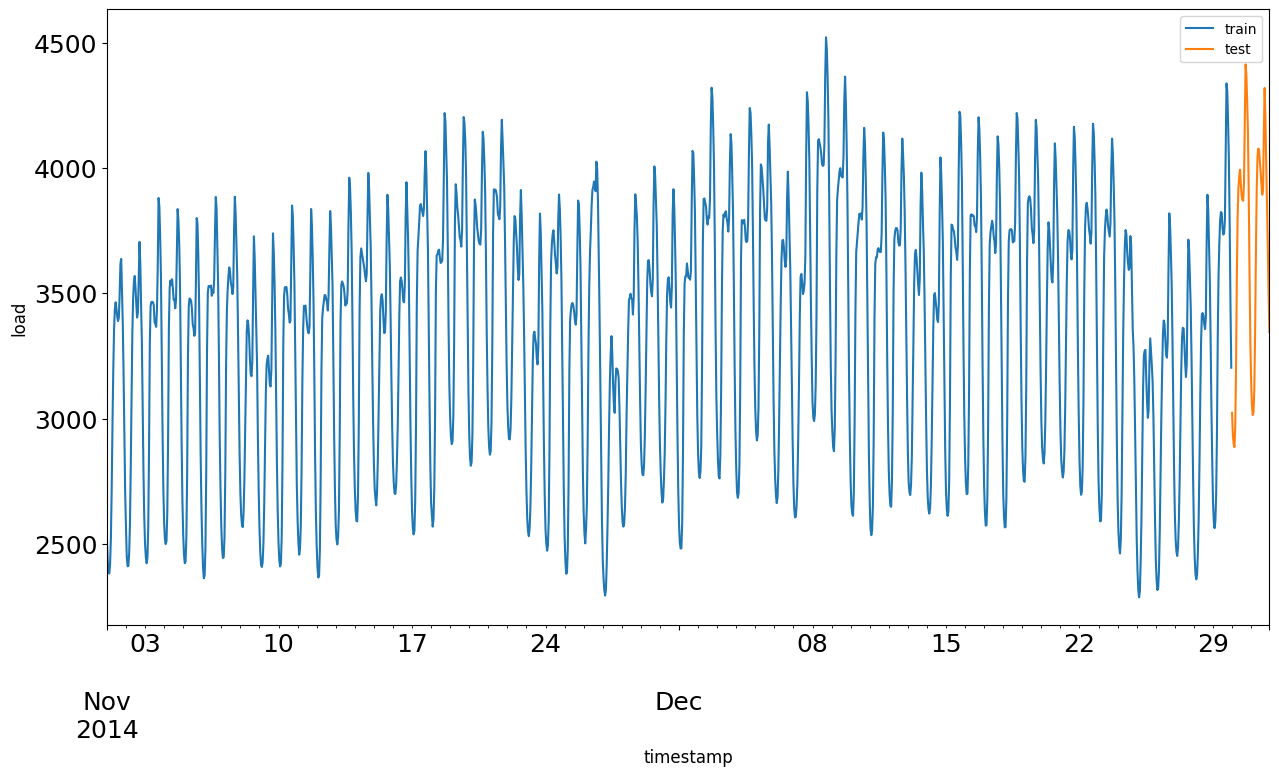

In [40]:
result.plot(y=['train', 'test'], figsize=(15, 8), fontsize=18)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Prepare the data for training

We will perform filtering and scaling of the data by:
- Filtering the dataset to only include the time perirods and columns you need, and
- Scaling to ensure the data is projected in the interval 0,1.

train-test split

In [17]:
# train = energy_df.copy()[
#     (energy_df.index >= train_start_dt) &
#      (energy_df.index < test_start_dt)][['load']]

# test = energy_df.copy()[energy_df.index >= test_start_dt][['load']]

# print('Training data shape: ', train.shape)
# print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [14]:
train = energy_df.loc[
    (energy_df.index >= train_start_dt) &
    (energy_df.index < test_start_dt),
    "load"
]

test = energy_df.loc[
    energy_df.index >= test_start_dt,
    "load"
]


In [30]:
# train.describe()
# check if train is dataframe
type(train)

pandas.core.frame.DataFrame

scaling

In [17]:
# # Scale data: 0,1
# scaler = MinMaxScaler()
# train['load'] = scaler.fit_transform(train)
# train.head(10)

In [24]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(
    train.values.reshape(-1, 1)
).flatten()

test_scaled = scaler.transform(
    test.values.reshape(-1, 1)
).flatten()

In [26]:
train_scaled

array([0.10161146, 0.06580125, 0.04610564, ..., 0.66741271, 0.52461952,
       0.41002686])

In [19]:
# # scale the test data
# test['load'] = scaler.transform(test)
# test.head(10)

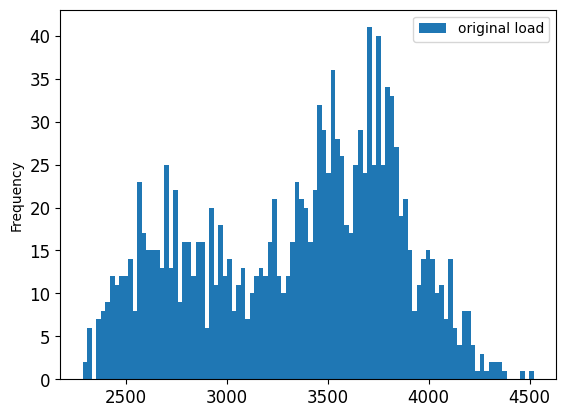

In [33]:
energy_df[
    (energy_df.index >= train_start_dt) &
     (energy_df.index < test_start_dt)][['load']] \
.rename(columns={'load':'original load'}) \
.plot.hist(bins=100, fontsize=12)

# train.rename('scaled load').plot.hist(bins=100, fontsize=12)
plt.show()


In [36]:
#save state of data scaler in .joblib file
dump(scaler, f'{path}models/energen_scaler.joblib')

['drive/MyDrive/_Machine_Learning/project_energen/models/energen_scaler.joblib']

## Implementing ARIMA

Since our data is a seasonal one, we will use a seasonal ARIMA model (SARIMA) and parameters: P, D and Q.

In [37]:
HORIZON = 3
print("Forecasting horizon:", HORIZON, "hours")

Forecasting horizon: 3 hours


Implementing ARIMA with "auto_arima" from "pmdarima", taking note of seasonality in dataset

In [38]:
model = auto_arima(
    train_scaled,
    seasonal=True,
    m=24,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action="ignore",
)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-7102.266, Time=19.66 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-3309.854, Time=0.20 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=9.76 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-5742.975, Time=8.23 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-3311.842, Time=0.15 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=inf, Time=20.13 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-6952.398, Time=20.42 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-7111.026, Time=82.75 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-6998.421, Time=97.94 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=81.86 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-7255.632, Time=75.70 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=-6482.275, Time=71.25 sec
 ARIMA(1,1,2)(1,0,2)[24] intercept   : AIC=-7276.283, Time=75.18 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=-6449.916, Time=72.44 sec
 ARIMA(1,1,2)

In [41]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1416
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 24)   Log Likelihood                3695.574
Date:                            Mon, 19 Jan 2026   AIC                          -7375.148
Time:                                    18:52:07   BIC                          -7333.109
Sample:                                         0   HQIC                         -7359.441
                                           - 1416                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e-06      0.000      0.014      0.989      -0.000       0.000
ma.L1          0.9058      0.018     50.283      0.000       0.870       0.941
ma.L2          0.3138      0.021     15.231      0.000       0.273       0.354
ar.S.L24       0.6766      0.064     10.652      0.000       0.552       0.801
ar.S.L48       0.2994      0.060      4.952      0.000       0.181       0.418
ma.S.L24      -0.1760      0.063     -2.810      0.005      -0.299      -0.053
ma.S.L48      -0.4720      0.036    -13.228      0.000      -0.542      -0.402
sigma2         0.0003   8.65e-06     35.111      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):               455.50
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Save the trained auto_arima model for further processing and production use

In [42]:
dump(model, f'{path}models/energen_sarima_auto_model.joblib')

config = {
    "order": model.order,
    "seasonal_order": model.seasonal_order,
    "m": 24,
    "scaler": "MinMaxScaler",
    "train_Start": str(train.index.min()),
    "train_end": str(train.index.max()),
}

with open(f"{path}models/energen_sarima_auto_config.json", "w") as f:
    json.dump(config, f, indent=4)

## Forecast using model

In [44]:
forecast_scaled = model.predict(n_periods=HORIZON)
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).ravel()

print("Forecast (Original scale):", forecast)

Forecast (Original scale): [3014.61090562 2927.03629037 2890.65109437]


## Evaluate the Model

load model

In [45]:
model = load(f'{path}models/energen_sarima_auto_model.joblib')
model_config = json.load(open(f"{path}models/energen_sarima_auto_config.json"))

In [49]:
test_shifted = test.to_frame(name='load') # Convert Series to DataFrame with 'load' as column name

for t in range(1, HORIZON+1):
    test_shifted[f'load{t}'] = test_shifted['load'].shift(-t, freq='h') # Create columns like 'load1', 'load2', etc.

test_shifted = test_shifted.dropna(how='any')

In [55]:
# Compare forecast to first horizon of test
eval_df = pd.DataFrame({
    'timestamp': test_shifted.index[:HORIZON],
    'forecast': forecast,
    'actual': test_shifted[['load']].iloc[:HORIZON].values.ravel()
})
eval_df

,timestamp,forecast,actual
0,2014-12-30 00:00:00,3014.610906,3023.0
1,2014-12-30 01:00:00,2927.036290,2935.0
2,2014-12-30 02:00:00,2890.651094,2899.0


In [52]:
test_shifted.head()

,load,load1,load2,load3
timestamp,,,,
2014-12-30 00:00:00,3023.0,2935.0,2899.0,2886.0
2014-12-30 01:00:00,2935.0,2899.0,2886.0,2963.0
2014-12-30 02:00:00,2899.0,2886.0,2963.0,3199.0
2014-12-30 03:00:00,2886.0,2963.0,3199.0,3558.0
2014-12-30 04:00:00,2963.0,3199.0,3558.0,3806.0


In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = model_config["order"]
seasonal_order = model_config["seasonal_order"]

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 00:00:00
1 : predicted = [0.32 0.28 0.26] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323, 0.26812891674127126]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 01:00:00
2 : predicted = [0.29 0.28 0.28] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126, 0.3025962399283795]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 02:00:00
3 : predicted = [0.27 0.27 0.31] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795, 0.40823634735899716]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 03:00:00
4 : predicted = [0.28 0.31 0.4 ] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716, 0.5689346463742166]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 04:00:00
5 : predicted = [0.29 0.37 0.51] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166, 0.6799462846911368]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 05:00:00
6 : predicted = [0.39 0.53 0.64] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368, 0.7309758281110115]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 06:00:00
7 : predicted = [0.56 0.67 0.74] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115, 0.7511190689346463]
2014-12-30 07:00:00
8 : predicted = [0.69 0.75 0.79] expected = [0.6799462846911368, 0.7309758281110115, 0.7511190689346463, 0.7636526410026856]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 08:00:00
9 : predicted = [0.74 0.77 0.78] expected = [0.7309758281110115, 0.7511190689346463, 0.7636526410026856, 0.7381378692927483]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 09:00:00
10 : predicted = [0.76 0.76 0.76] expected = [0.7511190689346463, 0.7636526410026856, 0.7381378692927483, 0.7188898836168307]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 10:00:00
11 : predicted = [0.75 0.75 0.72] expected = [0.7636526410026856, 0.7381378692927483, 0.7188898836168307, 0.7090420769919425]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 11:00:00
12 : predicted = [0.77 0.74 0.72] expected = [0.7381378692927483, 0.7188898836168307, 0.7090420769919425, 0.7081468218442255]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 12:00:00
13 : predicted = [0.68 0.64 0.63] expected = [0.7188898836168307, 0.7090420769919425, 0.7081468218442255, 0.7385854968666068]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 13:00:00
14 : predicted = [0.72 0.72 0.74] expected = [0.7090420769919425, 0.7081468218442255, 0.7385854968666068, 0.8478066248880931]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 14:00:00
15 : predicted = [0.7  0.71 0.83] expected = [0.7081468218442255, 0.7385854968666068, 0.8478066248880931, 0.9516562220232765]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 15:00:00
16 : predicted = [0.73 0.85 0.94] expected = [0.7385854968666068, 0.8478066248880931, 0.9516562220232765, 0.934198746642793]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 16:00:00
17 : predicted = [0.86 0.96 0.94] expected = [0.8478066248880931, 0.9516562220232765, 0.934198746642793, 0.8876454789615038]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 17:00:00
18 : predicted = [0.93 0.91 0.87] expected = [0.9516562220232765, 0.934198746642793, 0.8876454789615038, 0.8294538943598924]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 18:00:00
19 : predicted = [0.95 0.92 0.86] expected = [0.934198746642793, 0.8876454789615038, 0.8294538943598924, 0.7197851387645477]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 19:00:00
20 : predicted = [0.88 0.82 0.72] expected = [0.8876454789615038, 0.8294538943598924, 0.7197851387645477, 0.5747538048343777]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 20:00:00
21 : predicted = [0.83 0.74 0.61] expected = [0.8294538943598924, 0.7197851387645477, 0.5747538048343777, 0.4592658907788718]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 21:00:00
22 : predicted = [0.73 0.6  0.49] expected = [0.7197851387645477, 0.5747538048343777, 0.4592658907788718, 0.3858549686660697]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 22:00:00
23 : predicted = [0.58 0.47 0.38] expected = [0.5747538048343777, 0.4592658907788718, 0.3858549686660697, 0.34377797672336596]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-30 23:00:00
24 : predicted = [0.45 0.37 0.33] expected = [0.4592658907788718, 0.3858549686660697, 0.34377797672336596, 0.32542524619516544]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 00:00:00
25 : predicted = [0.38 0.34 0.32] expected = [0.3858549686660697, 0.34377797672336596, 0.32542524619516544, 0.33034914950760963]
2014-12-31 01:00:00
26 : predicted = [0.35 0.33 0.33] expected = [0.34377797672336596, 0.32542524619516544, 0.33034914950760963, 0.3706356311548791]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 02:00:00
27 : predicted = [0.32 0.31 0.34] expected = [0.32542524619516544, 0.33034914950760963, 0.3706356311548791, 0.470008952551477]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 03:00:00
28 : predicted = [0.32 0.35 0.43] expected = [0.33034914950760963, 0.3706356311548791, 0.470008952551477, 0.6145926589077886]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 04:00:00
29 : predicted = [0.37 0.45 0.57] expected = [0.3706356311548791, 0.470008952551477, 0.6145926589077886, 0.7247090420769919]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 05:00:00
30 : predicted = [0.46 0.58 0.69] expected = [0.470008952551477, 0.6145926589077886, 0.7247090420769919, 0.786034019695613]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 06:00:00
31 : predicted = [0.61 0.72 0.79] expected = [0.6145926589077886, 0.7247090420769919, 0.786034019695613, 0.8012533572068039]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 07:00:00
32 : predicted = [0.73 0.8  0.85] expected = [0.7247090420769919, 0.786034019695613, 0.8012533572068039, 0.7994628469113696]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 08:00:00
33 : predicted = [0.79 0.84 0.86] expected = [0.786034019695613, 0.8012533572068039, 0.7994628469113696, 0.780214861235452]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 09:00:00
34 : predicted = [0.82 0.84 0.83] expected = [0.8012533572068039, 0.7994628469113696, 0.780214861235452, 0.7587287376902416]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 10:00:00
35 : predicted = [0.8  0.78 0.76] expected = [0.7994628469113696, 0.780214861235452, 0.7587287376902416, 0.7367949865711727]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 11:00:00
36 : predicted = [0.77 0.76 0.75] expected = [0.780214861235452, 0.7587287376902416, 0.7367949865711727, 0.7188898836168307]
2014-12-31 12:00:00
37 : predicted = [0.77 0.76 0.76] expected = [0.7587287376902416, 0.7367949865711727, 0.7188898836168307, 0.7273948075201431]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 13:00:00
38 : predicted = [0.74 0.73 0.76] expected = [0.7367949865711727, 0.7188898836168307, 0.7273948075201431, 0.8299015219337511]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 14:00:00
39 : predicted = [0.73 0.75 0.86] expected = [0.7188898836168307, 0.7273948075201431, 0.8299015219337511, 0.909579230080573]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 15:00:00
40 : predicted = [0.73 0.84 0.92] expected = [0.7273948075201431, 0.8299015219337511, 0.909579230080573, 0.855863921217547]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 16:00:00
41 : predicted = [0.82 0.9  0.88] expected = [0.8299015219337511, 0.909579230080573, 0.855863921217547, 0.7721575649059982]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 17:00:00
42 : predicted = [0.91 0.88 0.82] expected = [0.909579230080573, 0.855863921217547, 0.7721575649059982, 0.7023276633840643]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 18:00:00
43 : predicted = [0.88 0.83 0.77] expected = [0.855863921217547, 0.7721575649059982, 0.7023276633840643, 0.6195165622202325]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 19:00:00
44 : predicted = [0.78 0.71 0.61] expected = [0.7721575649059982, 0.7023276633840643, 0.6195165622202325, 0.5425246195165621]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2014-12-31 20:00:00
45 : predicted = [0.7  0.6  0.47] expected = [0.7023276633840643, 0.6195165622202325, 0.5425246195165621, 0.4735899731423454]
CPU times: user 23min 33s, sys: 17.3 s, total: 23min 50s
Wall time: 15min 1s


In [31]:
eval_df = pd.DataFrame(
    predictions,
    columns=[f"t+{t}" for t in range(1, HORIZON + 1)]
)

eval_df["timestamp"] = test_shifted.index

eval_df = pd.melt(
    eval_df,
    id_vars="timestamp",
    value_name="prediction",
    var_name="h"
)

actual_cols = [f"load{t}" for t in range(1, HORIZON + 1)]
eval_df["actual"] = test_shifted[actual_cols].values.ravel()

eval_df[["prediction", "actual"]] = scaler.inverse_transform(
    eval_df[["prediction", "actual"]].values
)

In [32]:
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,012.02","2,935.00"
1,2014-12-30 01:00:00,t+1,"2,945.91","2,899.00"
2,2014-12-30 02:00:00,t+1,"2,891.53","2,886.00"
3,2014-12-30 03:00:00,t+1,"2,908.54","2,899.00"
4,2014-12-30 04:00:00,t+1,"2,939.11","2,886.00"


## check Model Accuracy

Using MAPE.



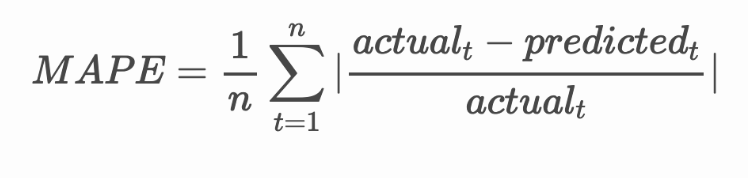

MAPE is used to show prediction accuracy as a ratio defined by the above formula. The difference between actualt and predictedt is divided by the actualt. "The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n.

In [56]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# mae = mean_absolute_error(test.values, forecast)
# rmse = np.sqrt(mean_squared_error(test.values, forecast))

# print(f"MAE: {mae:.2f}")
# print(f"RMSE: {rmse:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [48, 3]

In [33]:
def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

In [34]:
if(HORIZON > 1):
    eval_df['APE'] = (
        (eval_df['prediction'] - eval_df['actual']).abs()
        / eval_df['actual']
    )
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.11
t+2   0.16
t+3   0.11
Name: APE, dtype: float64


In [35]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  1055.0723678611694 %


In [36]:
one_step = eval_df[eval_df["h"] == "t+1"]

print(
    "One step forecast MAPE:",
    mape(one_step["actual"], one_step["prediction"]),
    "%"
)

print(
    "Multiple step forecast MAPE:",
    mape(eval_df["actual"], eval_df["prediction"]),
     "%"
)

One step forecast MAPE: 10.531190216189326 %
Multiple step forecast MAPE: 12.472019940760509 %


In [37]:
eval_df['APE'].describe()

,APE
count,135.00
mean,0.12
std,0.10
min,0.00
25%,0.03
50%,0.09
75%,0.21
max,0.38


In [38]:
eval_df.head()

,timestamp,h,prediction,actual,APE
0,2014-12-30 00:00:00,t+1,"3,012.02","2,935.00",0.03
1,2014-12-30 01:00:00,t+1,"2,945.91","2,899.00",0.02
2,2014-12-30 02:00:00,t+1,"2,891.53","2,886.00",0.00
3,2014-12-30 03:00:00,t+1,"2,908.54","2,899.00",0.00
4,2014-12-30 04:00:00,t+1,"2,939.11","2,886.00",0.02


In [42]:
from sklearn.metrics import mean_absolute_error

eval_df.groupby('h').apply(
    lambda x: mean_absolute_error(x['actual'], x['prediction'])
)


/tmp/ipython-input-354944092.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eval_df.groupby('h').apply(


,0
h,
t+1,380.34
t+2,582.88
t+3,427.55


/tmp/ipython-input-2430862642.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


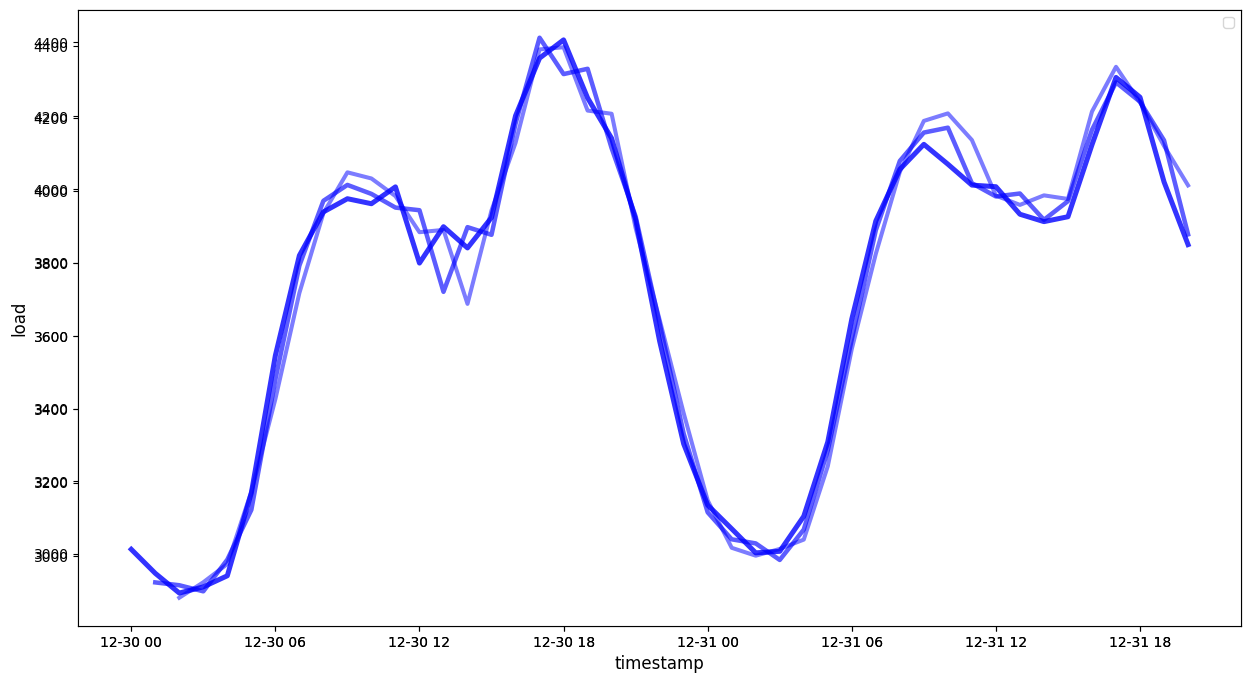

In [40]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))

    ax.legend(loc='best')

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()